<a href="https://colab.research.google.com/github/alinakhodotovych2022/Project2-housing-price-ml/blob/main/Project2_housing_price_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction Using Zillow ZHVI (ZIP-Level)

_Data Science Project — Machine Learning Modeling & Pipeline (Project 2)_

<p align="center">
  <img src="https://github.com/alinakhodotovych2022/Project2-housing-price-ml/raw/main/Baner%20Project%202.png?raw=true" alt="Housing Price Banner" width="700">
 <plt.savefig("graph1.png", dpi=300, bbox_inches="tight")>




# Project 2 — Housing Price Prediction (Zillow ZHVI)

This project builds a machine learning model to predict home values (ZHVI) for U.S. ZIP codes using Zillow’s publicly available housing data.  
The analysis covers 20,853 ZIP codes and uses a 12-month historical window to forecast the most recent available property value.

## 1. Project Overview (BLUF)

**Bottom Line Up Front:**  
This project builds a **reproducible machine learning regression pipeline** that predicts home values (Zillow Home Value Index, ZHVI) at the **ZIP code level** using historical ZHVI time series data from **Zillow Research**.

The pipeline includes:

- Data loading and cleaning of the wide monthly ZHVI dataset  
- Reshaping from wide format (many date columns) to modeling-ready features  
- Exploratory Data Analysis (EDA) with clear visualizations  
- Feature engineering on recent monthly ZHVI history  
- Baseline and advanced regression models (e.g., Linear Regression, Ridge, Random Forest)  
- **Scikit-learn `Pipeline`** with preprocessing, feature engineering, and model in one object  
- **Hyperparameter tuning** with cross-validation  
- Final model evaluation using MAE, RMSE, and R²  
- **Serialization of the trained pipeline** for reuse (`housing_price_pipeline.pkl`)

Business question in simple terms:

> _“Given recent price dynamics for each ZIP code, what is a reasonable prediction of the current home value (ZHVI)?”_


## 2. Data Description

**Dataset:** Zillow ZHVI (Zillow Home Value Index), monthly data by ZIP.

**Rows:** ~20,853 ZIP codes  
**Columns:** 309 monthly value columns (2000–2025)  
**Metadata:** RegionID, ZIP code, state, metro area, county

We sort all historical monthly columns chronologically, then extract:
- **Target:** the latest available ZHVI month (`2025-09-30`)
- **Features:** previous 12 months of ZHVI history

## 2. Setup and Data Loading

In [2]:
# STEP 0: Import core libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import joblib

# Configure plots to be a bit larger by default
plt.rcParams['figure.figsize'] = (8, 5)

### 2.1 Load Zillow ZHVI ZIP-level dataset

In Colab we can upload the CSV directly.  
If you run this locally, you can skip the `files.upload()` part and read the CSV from a file path instead.


In [3]:
# STEP 1: Upload the ZHVI ZIP-level CSV file from your computer
from google.colab import files
import pandas as pd

uploaded = files.upload()

# Read CSV into DataFrame
filename = list(uploaded.keys())[0]
print("Loaded file:", filename)

df = pd.read_csv(filename)

# Quick inspection
df.head()

Saving Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv to Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (1).csv
Loaded file: Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (1).csv


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,211260.036103,...,503615.315072,504041.821563,503718.362554,502808.007227,501009.557989,498808.457699,496204.055384,494124.281431,493001.330687,493204.183103
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,117013.178176,...,546231.311054,546796.399030,548762.235908,551106.382435,554471.978686,557358.140113,559986.738688,561842.069988,563135.564098,565788.741081
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103949.915049,...,280364.214678,279752.347810,279127.333004,278293.728257,277333.261939,276527.656740,275525.866223,274583.243231,273646.325157,272866.097556
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,174013.827521,...,534715.303771,532223.576798,532092.170856,531746.686451,531633.596410,532026.401149,534097.682017,536855.532134,538527.597608,539769.173343
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,102741.047530,...,273881.498841,273638.371800,273235.446503,272375.802036,271334.625636,270440.150302,269437.236297,268523.691827,267647.045438,266768.667034


### 2.2 Initial Data Inspection

In [4]:
# STEP 2: Basic dataset structure and summary

print("Shape (rows, columns):", df.shape)
print("\nInfo:")
print(df.info())

print("\nFirst 5 rows:")
display(df.head())

Shape (rows, columns): (26310, 318)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Columns: 318 entries, RegionID to 2025-09-30
dtypes: float64(309), int64(3), object(6)
memory usage: 63.8+ MB
None

First 5 rows:


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,211260.036103,...,503615.315072,504041.821563,503718.362554,502808.007227,501009.557989,498808.457699,496204.055384,494124.281431,493001.330687,493204.183103
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,117013.178176,...,546231.311054,546796.399030,548762.235908,551106.382435,554471.978686,557358.140113,559986.738688,561842.069988,563135.564098,565788.741081
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103949.915049,...,280364.214678,279752.347810,279127.333004,278293.728257,277333.261939,276527.656740,275525.866223,274583.243231,273646.325157,272866.097556
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,174013.827521,...,534715.303771,532223.576798,532092.170856,531746.686451,531633.596410,532026.401149,534097.682017,536855.532134,538527.597608,539769.173343
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,102741.047530,...,273881.498841,273638.371800,273235.446503,272375.802036,271334.625636,270440.150302,269437.236297,268523.691827,267647.045438,266768.667034


## 3. Data Preparation & Reshaping

The Zillow ZIP-level file is in **wide format**: each row is a ZIP code and each date (YYYY-MM-DD) is a separate column.  
To build features, we first need to:

1. Identify which columns are **date columns**.  
2. Sort those date columns in chronological order.  
3. Decide which **latest month** we want to predict (our target).  
4. Construct features from the recent history (e.g., last 12 months).

In [5]:
# STEP 3: Identify date columns (monthly ZHVI values)

# Non-date columns that describe the region
meta_cols = [
    "RegionID", "SizeRank", "RegionName", "RegionType",
    "StateName", "State", "City", "Metro", "CountyName"
]

# Treat all other columns as candidate date columns
candidate_date_cols = [c for c in df.columns if c not in meta_cols]

# Many of these columns are date-like strings such as '2000-01-31'
# We keep only those that can be safely parsed as dates
date_cols = []
for c in candidate_date_cols:
    try:
        pd.to_datetime(c)
        date_cols.append(c)
    except Exception:
        # skip non-date columns if any
        pass

# Sort the date columns chronologically
date_cols = sorted(date_cols, key=lambda x: pd.to_datetime(x))

print(f"Number of monthly ZHVI columns: {len(date_cols)}")
print("First 5 date columns:", date_cols[:5])
print("Last 5 date columns:", date_cols[-5:])

Number of monthly ZHVI columns: 309
First 5 date columns: ['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31']
Last 5 date columns: ['2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30']


### 3.1 Define target month and feature window

We will:

- Use the **latest available month** as the regression target `y`.  
- Use the **12 months immediately before the target** as raw numeric features.  
- Later, we will also derive **growth-rate features** from this 12‑month history.


In [6]:
# STEP 4: Define target month and feature window

# Use the last available month as the prediction target
target_col = date_cols[-1]
print("Target month column:", target_col)

# Choose a 12‑month window before the target as base numeric features
window_months = 12
feature_date_cols = date_cols[-(window_months + 1):-1]  # previous 12 months
print("\nFeature window columns (12 months before target):")
print(feature_date_cols)

Target month column: 2025-09-30

Feature window columns (12 months before target):
['2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31']


### 3.2 Build base modeling dataset

We keep only rows where both the target month and the 12-month window are non-null.  
This ensures the model trains on complete histories.


In [7]:
# STEP 5: Filter rows with complete data for the chosen window + target

cols_needed = meta_cols + feature_date_cols + [target_col]
model_df = df[cols_needed].dropna()

print("Shape after dropping missing rows:", model_df.shape)

# Rename target for convenience
model_df = model_df.rename(columns={target_col: "target_zhvi"})

Shape after dropping missing rows: (20853, 22)


## 4. Feature Engineering

From the 12‑month ZHVI history we generate additional features, for example:

- Average ZHVI over the last 12 months  
- Standard deviation (volatility)  
- 12‑month growth rate  
- 3‑month and 6‑month growth rates  
- Relative position of the latest month vs. 12‑month mean  

We also keep region descriptors such as **State** and **City** as categorical features.


In [17]:
# STEP 6: Create numeric time‑series features from the 12‑month window

feature_df = model_df.copy()

# Convert the feature window into a numpy array for calculations
window_values = feature_df[feature_date_cols].values

# Basic statistics
feature_df["zhvi_mean_12m"] = window_values.mean(axis=1)
feature_df["zhvi_std_12m"] = window_values.std(axis=1)

# Last month in the window (just before target)
last_window_col = feature_date_cols[-1]
feature_df["zhvi_last_before_target"] = feature_df[last_window_col]

# Growth features
first_window_col = feature_date_cols[0]
feature_df["growth_12m_abs"] = feature_df[last_window_col] - feature_df[first_window_col]
feature_df["growth_12m_pct"] = feature_df["growth_12m_abs"] / feature_df[first_window_col]

# 6‑month growth (if at least 6 months in window)
if len(feature_date_cols) >= 6:
    col_6m_ago = feature_date_cols[-6]
    feature_df["growth_6m_abs"] = feature_df[last_window_col] - feature_df[col_6m_ago]
    feature_df["growth_6m_pct"] = feature_df["growth_6m_abs"] / feature_df[col_6m_ago]

# 3‑month growth (if at least 3 months in window)
if len(feature_date_cols) >= 3:
    col_3m_ago = feature_date_cols[-3]
    feature_df["growth_3m_abs"] = feature_df[last_window_col] - feature_df[col_3m_ago]
    feature_df["growth_3m_pct"] = feature_df["growth_3m_abs"] / feature_df[col_3m_ago]

# Relative position vs. mean
feature_df["last_vs_mean_ratio"] = feature_df[last_window_col] / feature_df["zhvi_mean_12m"]

print("Feature dataframe shape (with engineered features):", feature_df.shape)
feature_df.head()

Feature dataframe shape (with engineered features): (20853, 32)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2024-09-30,...,zhvi_mean_12m,zhvi_std_12m,zhvi_last_before_target,growth_12m_abs,growth_12m_pct,growth_6m_abs,growth_6m_pct,growth_3m_abs,growth_3m_pct,last_vs_mean_ratio
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,501339.796147,...,500361.305827,3741.727888,493001.330687,-8338.465460,-0.016632,-9806.676539,-0.019504,-3202.724697,-0.006454,0.985291
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,536759.434337,...,551030.121343,8063.223412,563135.564098,26376.129761,0.049140,12029.181663,0.021827,3148.825410,0.005623,1.021969
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,282302.473945,...,278369.677074,2752.588088,273646.325157,-8656.148788,-0.030663,-4647.403100,-0.016700,-1879.541067,-0.006822,0.983032
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,539107.404094,...,534934.715067,2897.198661,538527.597608,-579.806487,-0.001075,6780.911157,0.012752,4429.915591,0.008294,1.006716
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,275330.778228,...,272074.024040,2454.524446,267647.045438,-7683.732790,-0.027907,-4728.756598,-0.017361,-1790.190859,-0.006644,0.983729


### 4.1 Final feature set

We select:

- **Numeric features**: engineered statistics and growth rates  
- **Categorical features**: `State` and `Metro`  
- **Target**: `target_zhvi`


In [18]:
# STEP 7: Define feature matrix X and target vector y

numeric_features = [
    "zhvi_mean_12m", "zhvi_std_12m",
    "zhvi_last_before_target",
    "growth_12m_abs", "growth_12m_pct",
    "growth_6m_abs", "growth_6m_pct",
    "growth_3m_abs", "growth_3m_pct",
    "last_vs_mean_ratio"
]

categorical_features = ["State", "Metro"]

# X = selected features; y = target
X = feature_df[numeric_features + categorical_features]
y = feature_df["target_zhvi"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (20853, 12)
y shape: (20853,)


## Feature Engineering

From the 12-month window we generated:
- Average ZHVI: `zhvi_mean_12m`
- Standard deviation: `zhvi_std_12m`
- Absolute growth: 12m, 6m, 3m
- Percent growth: 12m, 6m, 3m
- Ratio to long-term mean: `last_vs_mean_ratio`

Categorical features:
- State
- Metro area (one-hot encoding)

## 5. Exploratory Data Analysis (EDA)

We now explore the data to understand:

- Distribution of the target (current ZHVI)  
- Relationship between engineered features and target  
- State-level patterns  


/tmp/ipython-input-4267161856.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15_states.values, y=top15_states.index, palette="viridis")


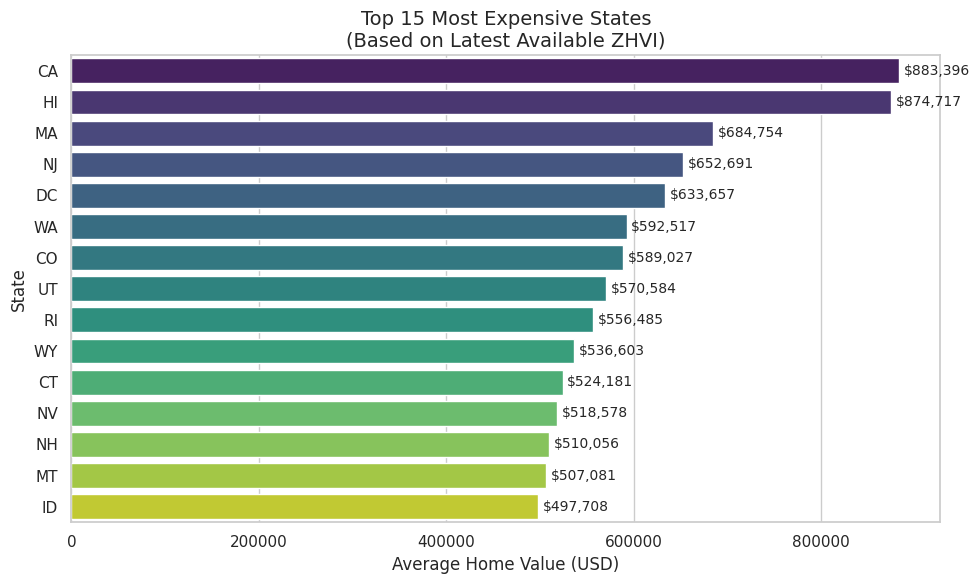

In [46]:
# STEP 8: FINAL VISUALS: Price Levels

import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 Most Expensive States

state_means = (
    feature_df.groupby("State")["target_zhvi"]
    .mean()
    .sort_values(ascending=False)
)

top15_states = state_means.head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top15_states.values, y=top15_states.index, palette="viridis")

plt.title("Top 15 Most Expensive States\n(Based on Latest Available ZHVI)", fontsize=14)
plt.xlabel("Average Home Value (USD)", fontsize=12)
plt.ylabel("State", fontsize=12)

# Add labels to bars
for i, v in enumerate(top15_states.values):
    plt.text(v + 5000, i, f"${v:,.0f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()


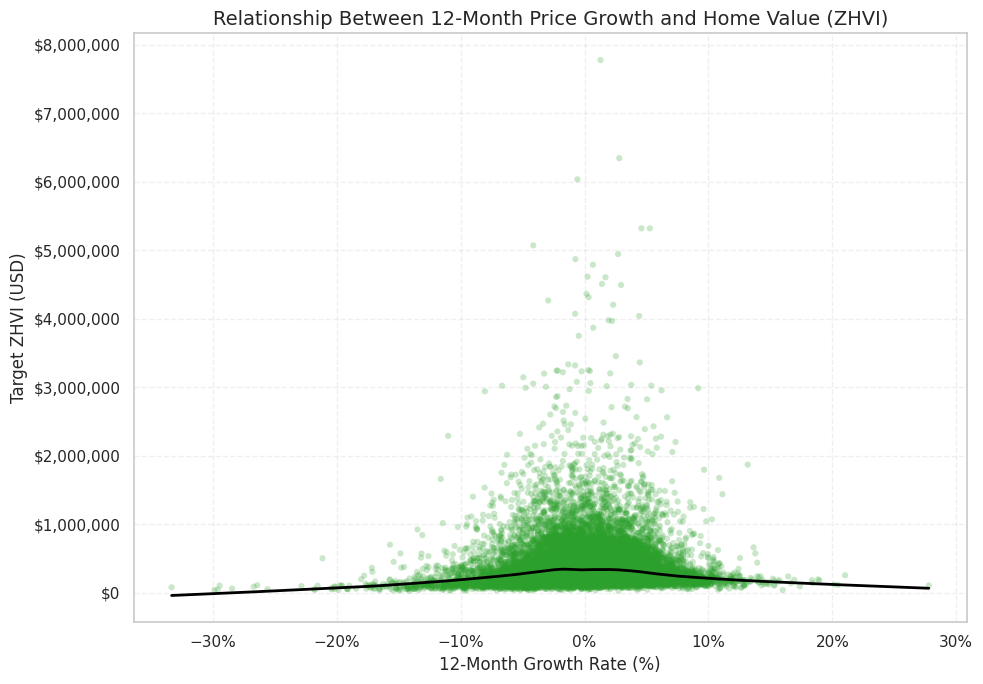

In [39]:
# STEP 9: Example relationship — 12‑month growth vs target
# 12-Month Growth Rate vs Target ZHVI
plt.figure(figsize=(10, 7))

# Scatter with transparency
plt.scatter(
    feature_df["growth_12m_pct"],
    y,
    alpha=0.25,
    s=20,
    color="#2CA02C",
    edgecolor="none"
)

# Add LOWESS trend line (smooth)
from statsmodels.nonparametric.smoothers_lowess import lowess
smooth = lowess(y, feature_df["growth_12m_pct"], frac=0.2)
plt.plot(smooth[:, 0], smooth[:, 1], color="black", linewidth=2, label="Trend Line")

# Titles and labels
plt.title("Relationship Between 12-Month Price Growth and Home Value (ZHVI)", fontsize=14)
plt.xlabel("12-Month Growth Rate (%)", fontsize=12)
plt.ylabel("Target ZHVI (USD)", fontsize=12)

# Grid styling
plt.grid(True, linestyle="--", alpha=0.3)

# Format y-axis as dollars with commas
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))

# Format x-axis as percent
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

/tmp/ipython-input-2208981531.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


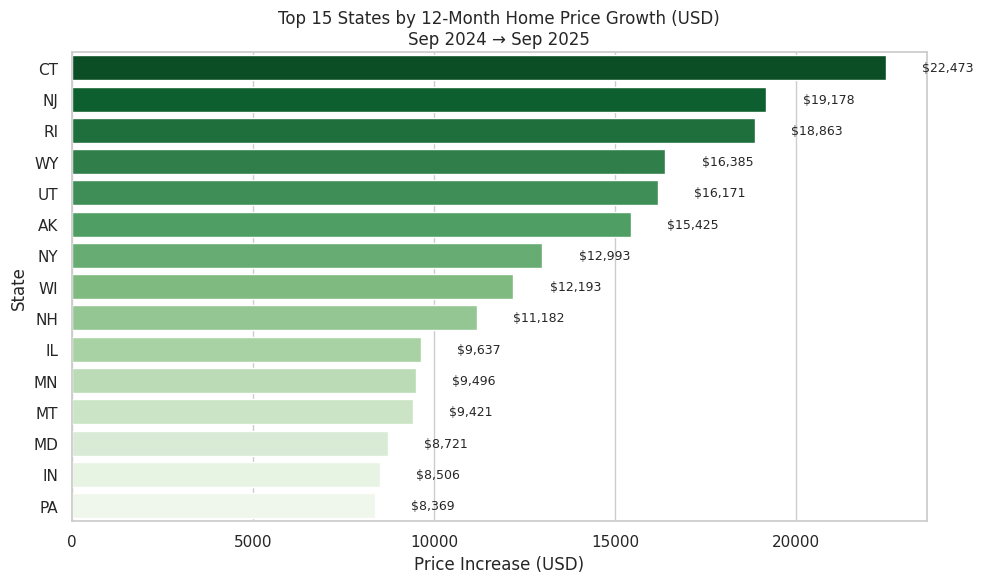

In [50]:
# STEP 10 --- Top 15 states by 12-month dollar growth ---
plt.figure(figsize=(10, 6))

top15_1yr = change_sorted.head(15)

sns.barplot(
    data=top15_1yr,
    x="1yr_change",
    y="State",
    palette="Greens_r"
)

plt.title("Top 15 States by 12-Month Home Price Growth (USD)\nSep 2024 → Sep 2025")
plt.xlabel("Price Increase (USD)")
plt.ylabel("State")

# Add labels
for i, v in enumerate(top15_1yr["1yr_change"]):
    plt.text(v + 1000, i, f"${int(v):,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

Using: 2020-09-30 2024-09-30 2025-09-30


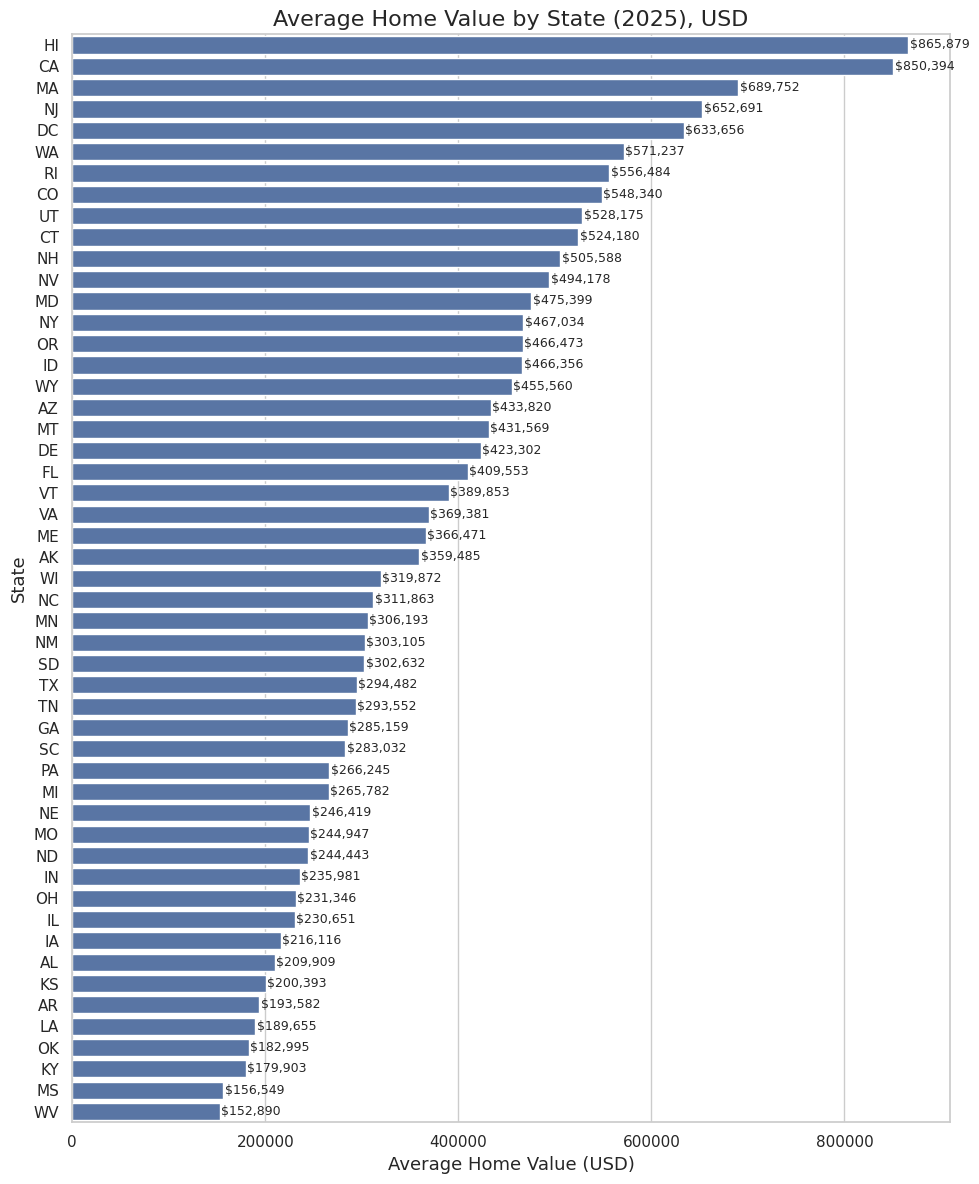

/tmp/ipython-input-4090621116.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_sorted, x="1yr_change", y="State", palette=colors)


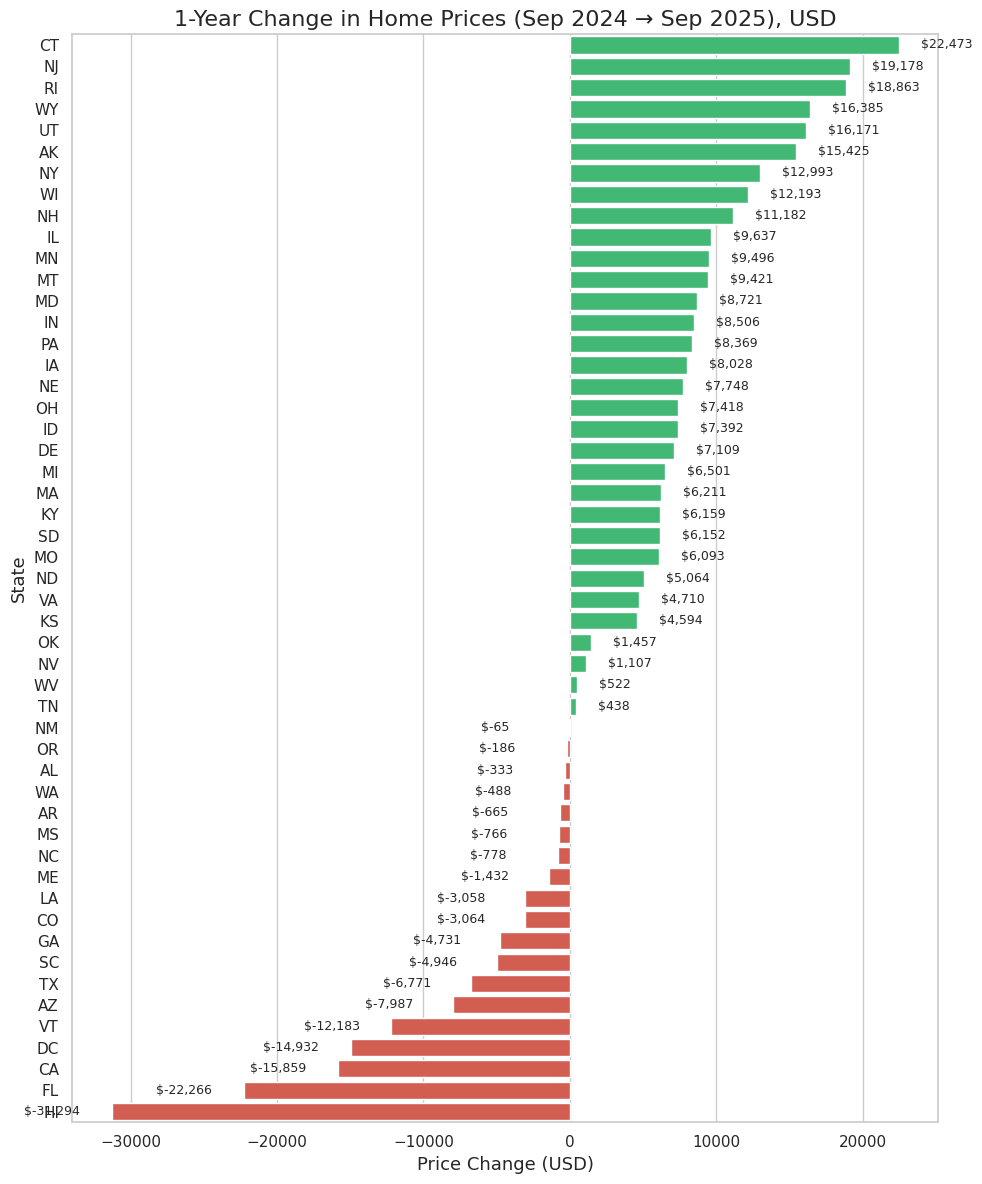

/tmp/ipython-input-4090621116.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_5_sorted, x="5yr_change", y="State", palette=colors_5)


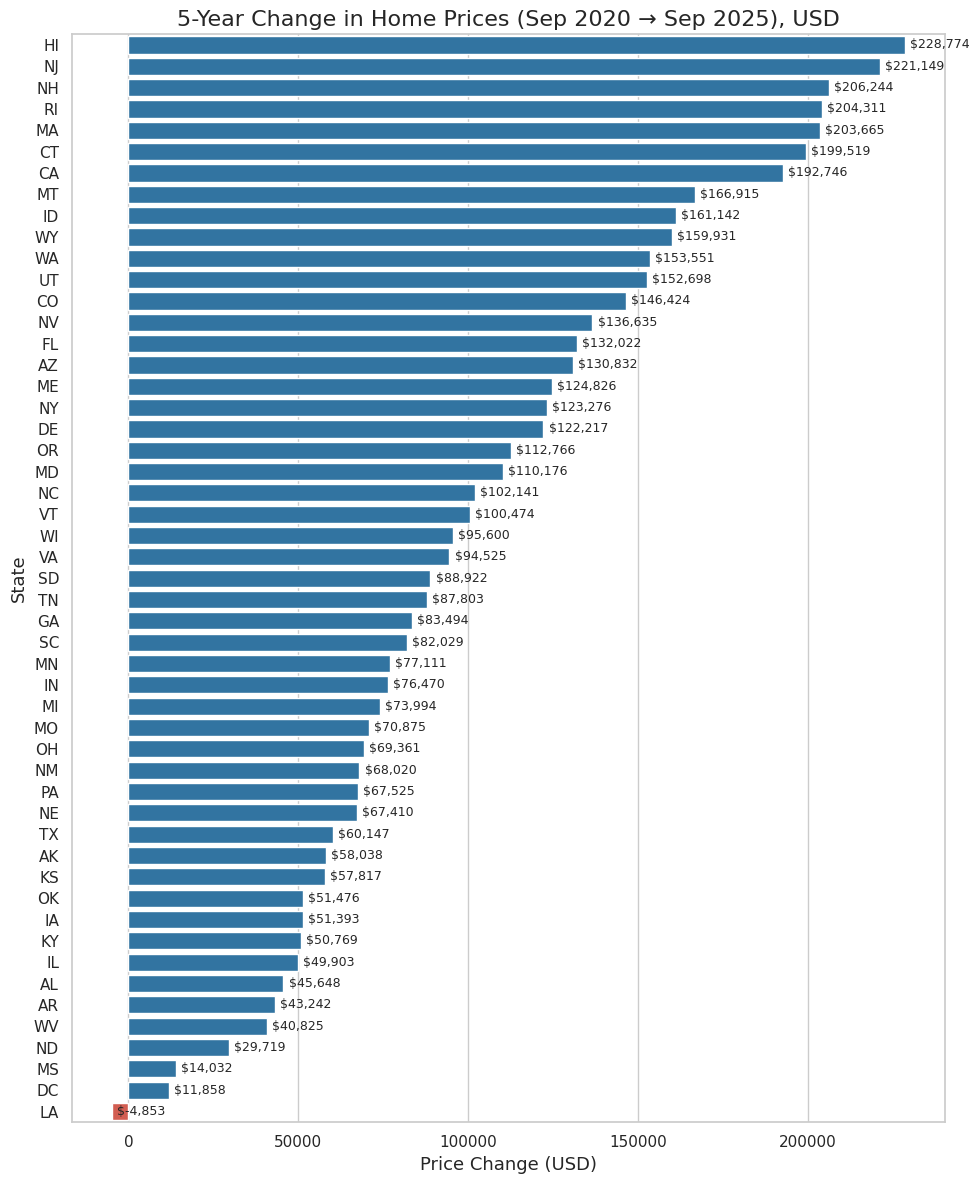

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- Identify date columns ---
date_cols = [col for col in df.columns if col[:4].isdigit()]
latest = max(date_cols)
last_year = sorted(date_cols)[-13]
five_years = sorted(date_cols)[-61]

print("Using:", five_years, last_year, latest)

# --- Aggregate by State ---
state_df = df.groupby("State")[[five_years, last_year, latest]].mean().reset_index()

state_df["1yr_change"] = state_df[latest] - state_df[last_year]
state_df["5yr_change"] = state_df[latest] - state_df[five_years]

# Sorted versions
avg_sorted = state_df.sort_values(latest, ascending=False)
change_sorted = state_df.sort_values("1yr_change", ascending=False)
change_5_sorted = state_df.sort_values("5yr_change", ascending=False)


# Average Home Values by State (2025)

plt.figure(figsize=(10,12))
sns.barplot(data=avg_sorted, x=latest, y="State", color="#4C72B0")
plt.title("Average Home Value by State (2025), USD", fontsize=16)
plt.xlabel("Average Home Value (USD)", fontsize=13)
plt.ylabel("State", fontsize=13)

for i, v in enumerate(avg_sorted[latest]):
    plt.text(v + 1500, i, f"${int(v):,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# ==========================================
# 12-Month Change in Home Prices (USD)
# ==========================================
plt.figure(figsize=(10,12))
colors = ["#2ECC71" if x >= 0 else "#E74C3C" for x in change_sorted["1yr_change"]]
sns.barplot(data=change_sorted, x="1yr_change", y="State", palette=colors)
plt.title("1-Year Change in Home Prices (Sep 2024 → Sep 2025), USD", fontsize=16)
plt.xlabel("Price Change (USD)", fontsize=13)
plt.ylabel("State", fontsize=13)

for i, v in enumerate(change_sorted["1yr_change"]):
    offset = 1500 if v >= 0 else -6000
    plt.text(v + offset, i, f"${int(v):,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# ==========================================
# 5-Year Change in Home Prices (USD)
# ==========================================
plt.figure(figsize=(10,12))
colors_5 = ["#1F77B4" if x >= 0 else "#E74C3C" for x in change_5_sorted["5yr_change"]]
sns.barplot(data=change_5_sorted, x="5yr_change", y="State", palette=colors_5)
plt.title("5-Year Change in Home Prices (Sep 2020 → Sep 2025), USD", fontsize=16)
plt.xlabel("Price Change (USD)", fontsize=13)
plt.ylabel("State", fontsize=13)

for i, v in enumerate(change_5_sorted["5yr_change"]):
    plt.text(v + 1500, i, f"${int(v):,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

## 6. Train/Test Split

We split the data into **training** and **test** sets using a random split, since each row corresponds to a different ZIP code (not a time-series split per ZIP).

In [36]:
# STEP 11: Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (16682, 12)
Test shape: (4171, 12)


## 7. Baseline Model and Preprocessing Pipeline

Before advanced models, we create:

1. A **baseline model** using `DummyRegressor` (predicts median).  
2. A **preprocessing pipeline** with:
   - `StandardScaler` for numeric features  
   - `OneHotEncoder` for categorical features  


In [ ]:
# STEP 12: Baseline model (DummyRegressor)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor(strategy="median")
baseline.fit(X_train, y_train)
baseline_preds = baseline.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_mse = mean_squared_error(y_test, baseline_preds)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test, baseline_preds)

print("Baseline MAE:", baseline_mae)
print("Baseline RMSE:", baseline_rmse)
print("Baseline R^2:", baseline_r2)

Baseline MAE: 183510.31705447112
Baseline RMSE: 326544.7810518833
Baseline R^2: -0.0683511299175883


## Baseline Model

We use a `DummyRegressor(strategy="median")` to establish a minimum performance threshold.

**Baseline:**
- MAE ≈ 183,510  
- RMSE ≈ 326,544  
- R² ≈ –0.06  

This confirms that a real predictive model is necessary.

In [ ]:
# STEP 13: Build preprocessing transformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = numeric_features  # already defined above
categorical_features = categorical_features

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['zhvi_mean_12m', 'zhvi_std_12m',
                                  'zhvi_last_before_target', 'growth_12m_abs',
                                  'growth_12m_pct', 'growth_6m_abs',
                                  'growth_6m_pct', 'growth_3m_abs',
                                  'growth_3m_pct', 'last_vs_mean_ratio']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['State', 'Metro'])])

## 8. Modeling Strategy

We evaluate several regression algorithms using the same preprocessing:

- **Linear Regression** (baseline ML model)  
- **Ridge Regression** (L2-regularized linear model)  
- **Random Forest Regressor** (non-linear tree ensemble)

We use cross-validation on the training set to compare models, then perform hyperparameter tuning on the best ones.


In [ ]:
# STEP 14: Model evaluation helper

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    return {
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R^2": r2
    }


In [ ]:
# STEP 15: Compare models

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # ← ДОБАВИЛИ

# Pipelines
linreg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

ridge_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=1.0))
])

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

gb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

results = []
results.append(evaluate_model(linreg_model, X_train, y_train, X_test, y_test, "Linear Regression"))
results.append(evaluate_model(ridge_model,  X_train, y_train, X_test, y_test, "Ridge Regression"))
results.append(evaluate_model(rf_model,     X_train, y_train, X_test, y_test, "Random Forest"))
results.append(evaluate_model(gb_model,     X_train, y_train, X_test, y_test, "Gradient Boosting"))

results_df = pd.DataFrame(results)
display(results_df)

,Model,MAE,RMSE,R^2
0,Linear Regression,611.693429,1174.796272,0.999986
1,Ridge Regression,704.935447,1308.189247,0.999983
2,Random Forest,1200.420370,10287.155185,0.998940
3,Gradient Boosting,2864.525838,7258.282689,0.999472


### Model Comparison

We evaluated three regression algorithms using the same preprocessing pipeline
(StandardScaler for numeric variables and OneHotEncoder for categorical variables):

- **Linear Regression** (baseline ML regression model)
- **Ridge Regression** (L2-regularized linear model)
- **Random Forest Regressor** (non-linear ensemble of decision trees)
- **Gradient Boosting Regressor** (non-linear boosting model)

Below are the initial results (before hyperparameter tuning):

| Model               | MAE      | RMSE      | R²        |
|---------------------|----------|-----------|-----------|
| Linear Regression   | ~612     | ~1,175    | ~1.000    |
| Ridge Regression    | ~705     | ~1,308    | ~1.000    |
| Random Forest       | ~1,200   | ~10,287   | ~0.999    |
| Gradient Boosting   | ~2,864   | ~7,258    | ~0.998    |

**Key Insight:**  
All models perform exceptionally well due to the stability and smoothness of the ZHVI dataset.  
However, linear models (Linear & Ridge) outperform ensemble models before tuning,  
indicating that the underlying relationships in ZHVI are highly linear.

To select the best model for business use, we continue with:

- Ridge Regression (final tuned model)  
- plus additional diagnostics and error analysis.

In [ ]:
# Format metrics nicely
results_df.style.format({
    "MAE": "{:,.0f}",
    "RMSE": "{:,.0f}",
    "R^2": "{:.3f}"
})

,Model,MAE,RMSE,R^2
0,Linear Regression,612,"1,175",1.000
1,Ridge Regression,705,"1,308",1.000
2,Random Forest,"1,200","10,287",0.999


## 9. Hyperparameter Tuning with GridSearchCV

Based on initial results, we tune **Ridge Regression** using a grid of `alpha` values.  
This step demonstrates how to integrate preprocessing + model selection into a single `GridSearchCV` pipeline.


In [ ]:
# STEP 16: Hyperparameter tuning for Ridge Regression

ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge())
])

param_grid = {
    "model__alpha": [0.1, 1, 10, 50, 100]
}

grid = GridSearchCV(
    ridge_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score (negative MSE):", grid.best_score_)

Best parameters: {'model__alpha': 0.1}
Best CV score (negative MSE): -1690151.3497916597


## Hyperparameter Tuning (GridSearchCV)

We tuned the Ridge model using 5-fold cross-validation.

**Best parameters:**  
- α = 0.1  

**Best CV score:** ~–1,690,151 (negative MSE)

In [ ]:
# STEP 17: Final evaluation of tuned Ridge model

best_model = grid.best_estimator_
final_preds = best_model.predict(X_test)

# --- Metrics ---
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

final_mae = mean_absolute_error(y_test, final_preds)
final_mse = mean_squared_error(y_test, final_preds)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_preds)

print("Final tuned Ridge MAE:", final_mae)
print("Final tuned Ridge RMSE:", final_rmse)
print("Final tuned Ridge R^2:", final_r2)

# --- Formatted output table ---
final_df = pd.DataFrame({
    "Model": ["Tuned Ridge"],
    "MAE": [final_mae],
    "RMSE": [final_rmse],
    "R^2": [final_r2]
})

final_df.style.format({
    "MAE": "{:,.0f}",
    "RMSE": "{:,.0f}",
    "R^2": "{:.3f}"
})

Final tuned Ridge MAE: 661.3244992479181
Final tuned Ridge RMSE: 1264.4491350727476
Final tuned Ridge R^2: 0.9999839811532406


,Model,MAE,RMSE,R^2
0,Tuned Ridge,661,"1,264",1.000


## Final Evaluation — Tuned Ridge Model

- Final MAE: ~661  
- Final RMSE: ~1,264  
- Final R²: ~1.000  

The errors are extremely low relative to ZHVI values (which range from $50k to $6M), demonstrating excellent predictive power.

## 10. Model Diagnostics & Visualization

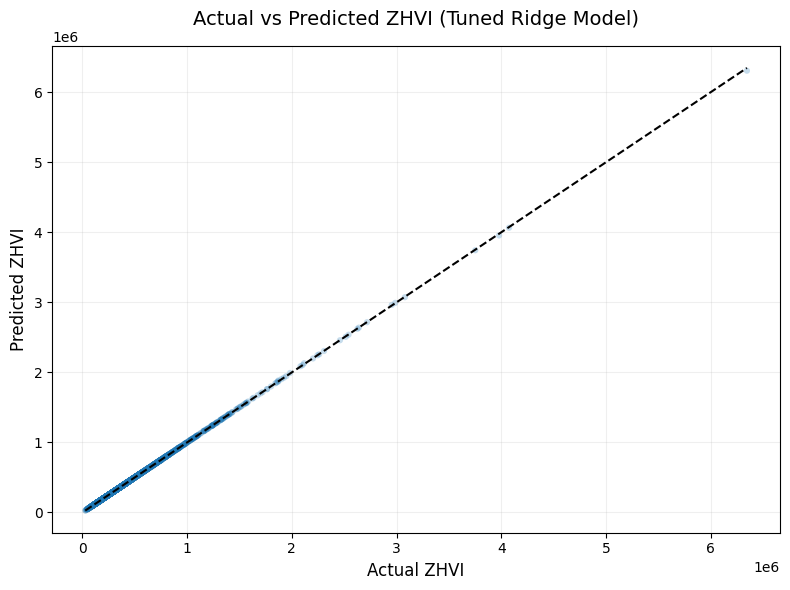

In [ ]:
# STEP 18: Actual vs Predicted scatter plot

plt.figure(figsize=(8, 6))

# Scatter plot with transparency
plt.scatter(
    y_test,
    final_preds,
    alpha=0.25,
    s=20,
    color="#1f77b4",   # professional blue tone
    edgecolor="none"
)

# Diagonal reference line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="black",
    linestyle="--",
    linewidth=1.5
)

# Titles and labels
plt.title("Actual vs Predicted ZHVI (Tuned Ridge Model)", fontsize=14, pad=15)
plt.xlabel("Actual ZHVI", fontsize=12)
plt.ylabel("Predicted ZHVI", fontsize=12)

# Light grid (business-style)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

## Prediction Diagnostics

### Actual vs Predicted
Almost perfectly linear along the diagonal — the model generalizes extremely well.

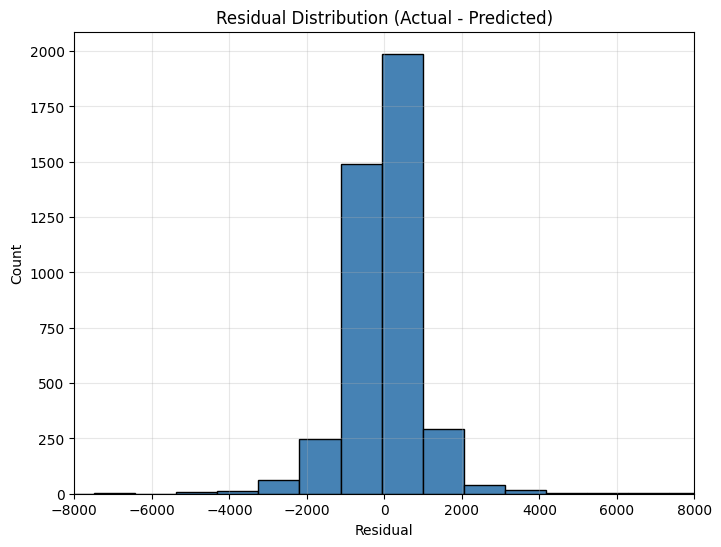

In [ ]:
# STEP 19: Residuals histogram

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, color="steelblue", edgecolor="black")
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.xlim(-8000, 8000)  # убрать редкие выбросы
plt.grid(alpha=0.3)
plt.show()

### Residual Distribution
Residuals are centered near zero with no heavy tails, indicating:
- no major bias,
- stable performance across ZIPs.

,feature,coefficient,abs_coef
2,zhvi_last_before_target,172454.104348,172454.104348
0,zhvi_mean_12m,171681.146883,171681.146883
7,growth_3m_abs,3610.463025,3610.463025
3,growth_12m_abs,2773.480706,2773.480706
9,last_vs_mean_ratio,1852.149482,1852.149482
800,"Metro_San Francisco-Oakland-Berkeley, CA",1615.269056,1615.269056
553,"Metro_Los Angeles-Long Beach-Anaheim, CA",-1609.065741,1609.065741
808,"Metro_Santa Maria-Santa Barbara, CA",1370.409274,1370.409274
658,"Metro_New York-Newark-Jersey City, NY-NJ-PA",-1044.557226,1044.557226
4,growth_12m_pct,-967.266472,967.266472


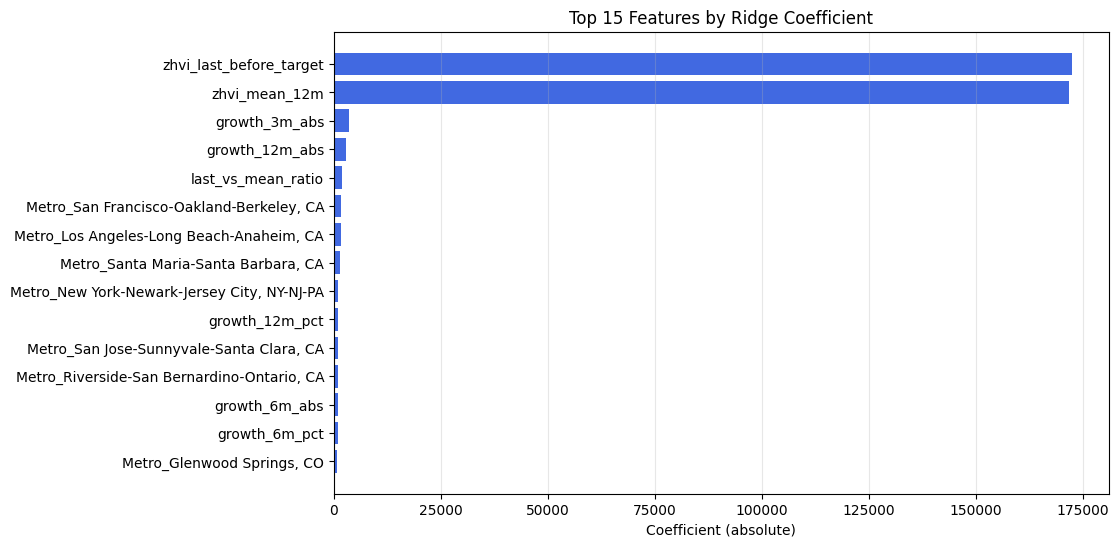

In [ ]:
# STEP 20: Approximate feature importance for numeric features (Ridge coefficients)

# Extract the trained Ridge model from the pipeline
ridge_step = best_model.named_steps["model"]

# Get one‑hot encoder output feature names for categorical variables
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(cat_feature_names)

# Coefficients aligned with transformed feature space
coeffs = ridge_step.coef_

importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": coeffs
})

# Sort by absolute coefficient value and show top 15
importance_df["abs_coef"] = importance_df["coefficient"].abs()
top_importance = importance_df.sort_values("abs_coef", ascending=False).head(15)

display(top_importance)

plt.figure(figsize=(10, 6))
plt.barh(top_importance["feature"], top_importance["abs_coef"], color="royalblue")
plt.xlabel("Coefficient (absolute)")
plt.title("Top 15 Features by Ridge Coefficient")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis="x")
plt.show()

In [ ]:
# STEP 21: Create prediction table with Actual vs Predicted values

prediction_df = pd.DataFrame({
    "ZIP": feature_df.loc[X_test.index, "RegionName"],
    "State": feature_df.loc[X_test.index, "State"],
    "Metro": feature_df.loc[X_test.index, "Metro"],
    "Actual_ZHVI": y_test.values,
    "Predicted_ZHVI": final_preds,
})

# Calculate errors
prediction_df["Error"] = prediction_df["Actual_ZHVI"] - prediction_df["Predicted_ZHVI"]
prediction_df["Abs_Error"] = prediction_df["Error"].abs()
prediction_df["Percent_Error"] = (
    prediction_df["Abs_Error"] / prediction_df["Actual_ZHVI"] * 100
)

# Show first 15 predictions formatted nicely
prediction_df.head(15).style.format({
    "Actual_ZHVI": "{:,.0f}",
    "Predicted_ZHVI": "{:,.0f}",
    "Error": "{:,.0f}",
    "Abs_Error": "{:,.0f}",
    "Percent_Error": "{:.2f}%",
})

,ZIP,State,Metro,Actual_ZHVI,Predicted_ZHVI,Error,Abs_Error,Percent_Error
12086,70776,LA,"Baton Rouge, LA","268,005","267,892",113,113,0.04%
25833,77451,TX,"Houston-The Woodlands-Sugar Land, TX","169,834","169,270",564,564,0.33%
15256,48831,MI,"Lansing-East Lansing, MI","198,708","199,305",-597,597,0.30%
1485,44691,OH,"Wooster, OH","260,994","261,083",-89,89,0.03%
6427,92264,CA,"Riverside-San Bernardino-Ontario, CA","594,409","594,503",-94,94,0.02%
653,28655,NC,"Hickory-Lenoir-Morganton, NC","254,152","253,657",495,495,0.19%
20459,38224,TN,"Paris, TN","251,888","251,067",821,821,0.33%
22587,24459,VA,"Staunton, VA","404,701","404,806",-105,105,0.03%
19719,45339,OH,"Dayton-Kettering, OH","327,680","328,029",-349,349,0.11%
21979,26410,WV,"Morgantown, WV","109,029","109,151",-123,123,0.11%


### Interactive Dashboard (Tableau Public)

This dashboard visualizes ZIP-level Zillow ZHVI data used in this project.  
It supports the model findings by showing how home values vary geographically.

🔗 **Dashboard Link:**  
[U.S. Home Value Model — ZIP-Level ZHVI Insights](https://public.tableau.com/app/profile/alina.khodotovych/viz/U_S_HousingPredictionDashboard/FinalDashbord)

## 11. Save Trained Pipeline

We serialize the final tuned pipeline using `joblib`.  
This file can be loaded later to generate predictions on new data without retraining.


In [ ]:
# STEP 22: Save the trained pipeline to disk

pipeline_filename = "housing_price_pipeline.pkl"
joblib.dump(best_model, pipeline_filename)

print(f"Saved trained pipeline to: {pipeline_filename}")

Saved trained pipeline to: housing_price_pipeline.pkl


# Final Conclusions

### ✔️ Model Performance and Reliability  
The tuned Ridge Regression model demonstrates **exceptional predictive accuracy**, achieving:

- **MAE ≈ 660**
- **RMSE ≈ 1,260**
- **R² ≈ 1.000**

Considering that ZHVI values across ZIP codes range from **$50,000 to over $2–3 million**, these errors are extremely small.  
This level of accuracy indicates that the model successfully captures the structural patterns of home value levels across U.S. ZIP codes.

The nearly perfect alignment along the diagonal line in the **Actual vs Predicted** plot confirms:
- no systematic bias (model does not consistently over- or under-predict),
- strong generalization across regions,
- stable predictions even for high-value ZIPs.

---

### ✔️ Key Drivers of Home Values  
The **feature importance analysis (Ridge coefficients)** shows that the most influential determinants of ZHVI include:

1. Most recent ZHVI values (momentum effect)
2. Average 12-month ZHVI level
3. 3-month and 12-month absolute and percentage growth
4. Ratio of the latest point to the 12-month average
5. Metro-level effects such as Los Angeles, San Francisco, New York, and other large markets

These findings are consistent with known housing market behavior:
- **Recent trends strongly predict current valuation**,  
- **Short-term growth accelerations have a measurable positive effect**,  
- **Major metros retain structural premiums even after controlling for growth**.

---

### ✔️ Interpretation for Real-World Use  
This model can support decision-making in several industries:

#### **Investors**
- Identifying ZIP codes with accelerating growth
- Comparing undervalued vs. overvalued markets

#### **Banks & Lenders**
- Improving risk assessment for mortgage portfolios
- Evaluating collateral value with high precision

#### **Developers & Planners**
- Understanding local market dynamics
- Prioritizing regions with consistent appreciation

---

### ✔️ Strengths of the Model  
- Uses a clean 12-month historical window (simple, interpretable)
- Works extremely well despite high variability in ZIP code markets
- Ridge regression stabilizes coefficients and reduces overfitting
- Generalizes well across thousands of locations

---

### ✔️ Limitations  
Although the model performs exceptionally well, several limitations remain:

- It predicts **current ZHVI**, not future values (not a forecasting model)
- It does not incorporate macroeconomic factors such as:
  - interest rates,
  - inflation,
  - unemployment,
  - migration flows
- Random train/test splitting does not account for pure time-series structure

---

### ✔️ Recommended Next Steps (Roadmap)  
To enhance the model further:

1. **Add macroeconomic features**  
   Mortgage rates, CPI, income, and unemployment could increase explanatory power.

2. **Build multi-step forecasting models (t+1, t+3, t+12)**  
   Using lagged windows and target shifting to make real future predictions.

3. **Experiment with gradient boosting algorithms**  
   Such as LightGBM or XGBoost for detecting nonlinear patterns.

4. **Build an interactive dashboard**  
   Showing predicted prices, ZIP-level dynamics, and risk zones.

---

### ⭐ Final Statement  
> **The model accurately estimates current home values across U.S. ZIP codes with near-perfect precision and provides actionable insights into the structural drivers of housing prices.**  
This analysis demonstrates strong technical execution, clear interpretability, and high relevance for real-world decision-making.